# Overview

I retrieved NBA players' statistics from 2011-2020 from basketball-reference.com via [basketball-reference-web-scraper](https://pypi.org/project/basketball-reference-web-scraper/) and NBA players' salaries from [ESPN](espn.com). The final dataset results from an inner join of these two datasets resulting in 3,233 observations and 44 predictors. Given the nature of the data sources and the combination method, there is no missingness in the data. All basic or "box-score" statistics (e.g. points and rebounds) were converted to per-48-minute averages. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/Users/erichochberger/Desktop/Stat_301_03_Final_Project/nba_salaries_and_stats_2011_2020')

train = data[(data['year'] != 2020)]


# Essential Findings

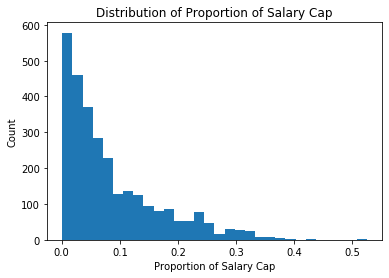

In [18]:
plt.hist(train['salary_prop'], bins=30)
plt.title('Distribution of Proportion of Salary Cap')
plt.xlabel('Proportion of Salary Cap')
plt.ylabel('Count')
plt.show()

The vast majority of players' salaries take up between 0 and 10% of the total salary cap. Let's examine whether or not the distribution has changed year over year. 

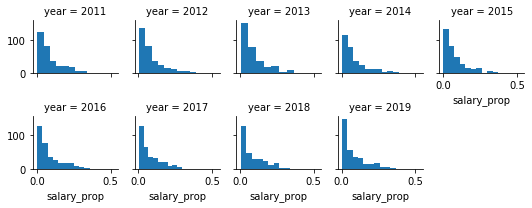

In [4]:
g = sns.FacetGrid(train, col = "year", col_wrap=5, height=1.5)
g = g.map(plt.hist, 'salary_prop')


It appears this distribution has remained relatively stable over time. We can also examine this by analyzing the median proportion by year.

In [5]:
train.groupby('year')['salary_prop'].agg('median')

year
2011    0.063745
2012    0.057903
2013    0.060299
2014    0.055727
2015    0.051978
2016    0.053571
2017    0.053111
2018    0.055699
2019    0.049083
Name: salary_prop, dtype: float64

It appears the median salary as a proportion of the cap has decreased over time. This is likely due to the trend of teams apportioning larger parts of their cap to star players. We can now examine the correlation between predictors to see if it makes sense to drop some. 

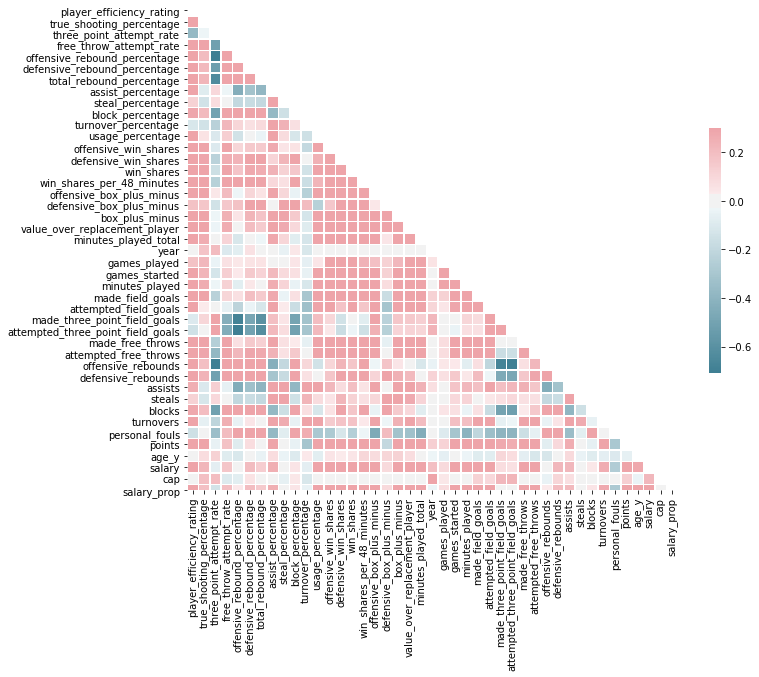

In [6]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

None of the predictors seem correlated enough to require dropping any. 

Value Over Replacement Player or VORP is an aggregate measure that takes into account all box score statistics and is meant to calculate a player's contribution to the team when that player is on the court according to (Basketball Reference)[https://www.basketball-reference.com/]. Since salary is meant to literally represent a player's value to the team we would hope that there is a positive correlation between this predictor and the response. 

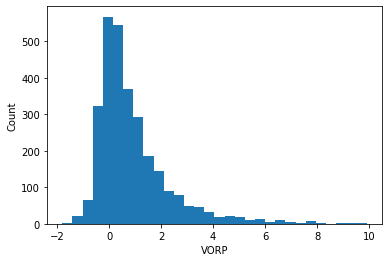

In [19]:
plt.hist(train['value_over_replacement_player'], bins=30)
plt.xlabel("VORP")
plt.ylabel("Count")
plt.show()

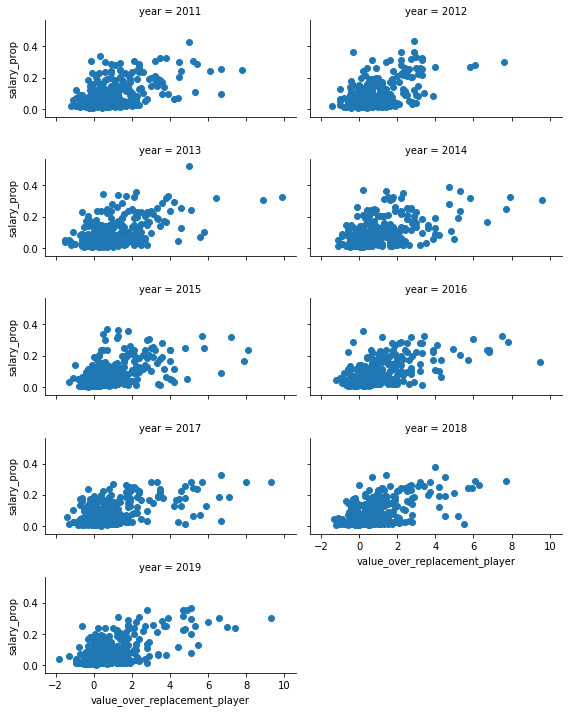

In [8]:
g = sns.FacetGrid(train, col = "year", col_wrap = 2, height = 2, aspect=2)
g = g.map(plt.scatter, 'value_over_replacement_player', 'salary_prop')




We see a generally positive relationship between a player's VORP and proportion of salary cap. Win Shares is another advanced statistic "which attempts to divvy up credit for team success to the individuals on the team" according to Basketball Reference.  While both VORP and Win Shares are "box-score" stats meaning that they are calculated using stats available in the typical box score in a newspaper, Win Shares differs from VORP in that it incorporates as a main component the team's win total, whereas VORP does not incorporate wins at all. 

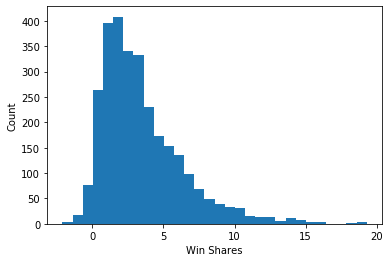

In [20]:
plt.hist(train['win_shares'], bins=30)
plt.xlabel("Win Shares")
plt.ylabel("Count")
plt.show()

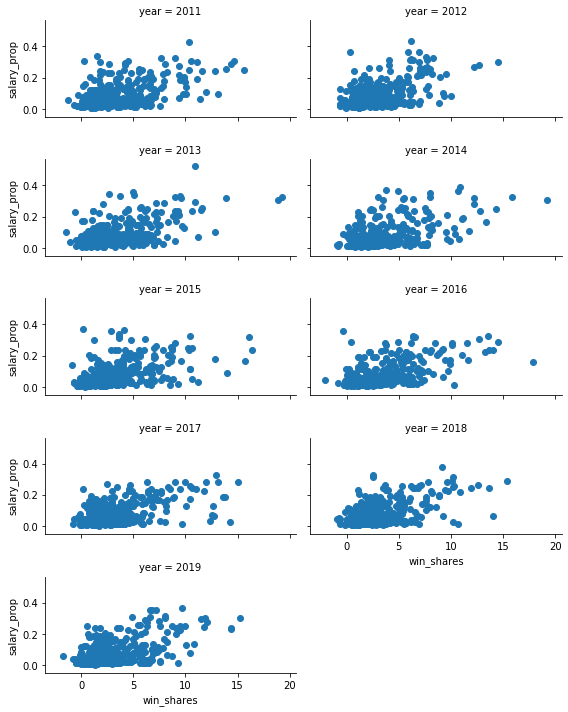

In [9]:
g = sns.FacetGrid(train, col = "year", col_wrap = 2, height = 2, aspect=2)
g = g.map(plt.scatter, 'win_shares', 'salary_prop')

This relationship is also generally positive. We can further examine how these two advanced statistics covary with each other.

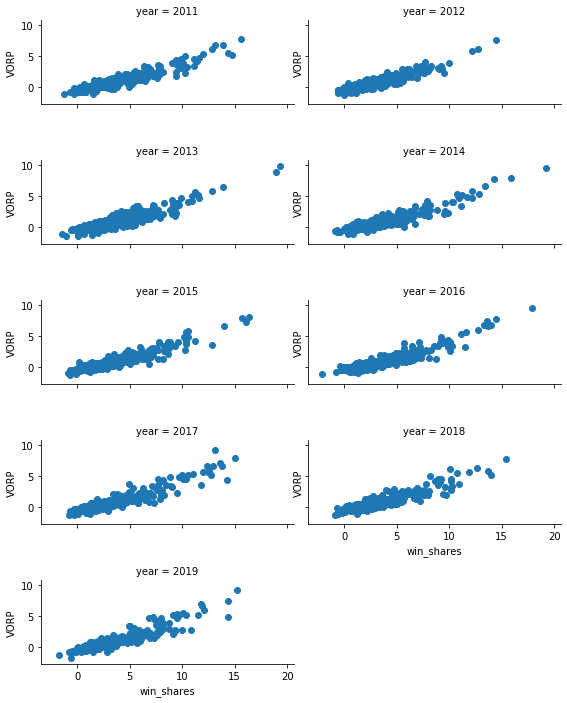

In [10]:
g = sns.FacetGrid(train, col = "year", col_wrap = 2, height = 2, aspect=2)
g = g.map(plt.scatter, 'win_shares', 'value_over_replacement_player')
for axes in g.axes.flat:
    axes.set_ylabel('VORP')

This appears to be a reliably positive linear relationship. This is somewhat intriguing given the calculations for each are complicated and incorporate different combinations of the box-score statistics in addition to linear regressions in the case of VORP and also have slightly different aims in what they portend to measure as mentioned above. 

Player Efficiency Rating (PER) is yet another advanced "box-score" statistic and it differs from VORP in that it is not "a catch-all stat that determines a player's ranking in the NBA hierarchy," but is supposed to "measure a player's per-minute productivity" according to ESPN. 


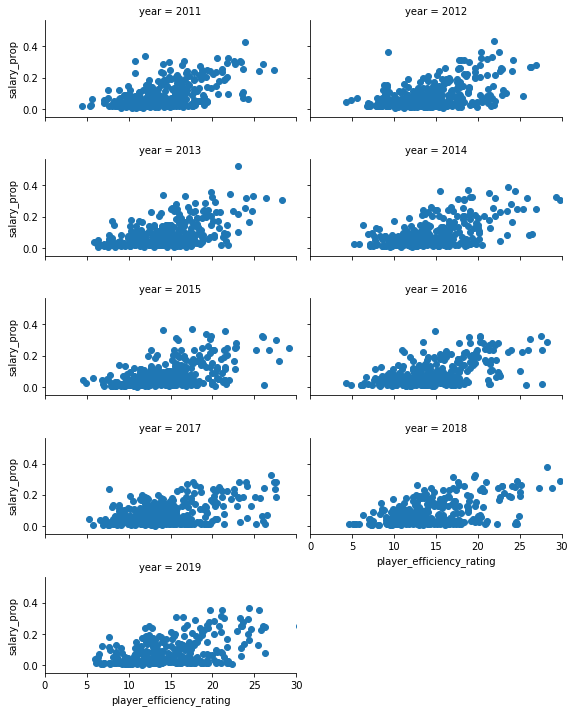

In [11]:
g = sns.FacetGrid(train, col = "year", col_wrap = 2, height = 2, aspect=2)
g = g.map(plt.scatter, 'player_efficiency_rating', 'salary_prop' )
for i, ax in enumerate(g.axes.flat): # change axis limits for plotgrid
        ax.set_xlim(0,30)

This doesn't make it very clear that there is a positive relationship, but by discretizing PER, we can see very clearly that there is one. 

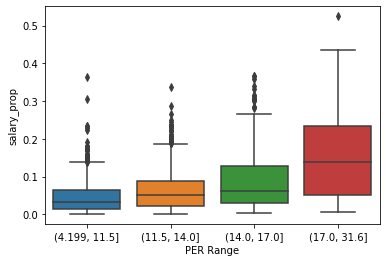

In [12]:
train['cut_per'] = pd.qcut(train['player_efficiency_rating'], q=4)
ax = sns.boxplot(x="cut_per",y="salary_prop",data=train)
ax = ax.set(xlabel = "PER Range")

# Secondary Findings

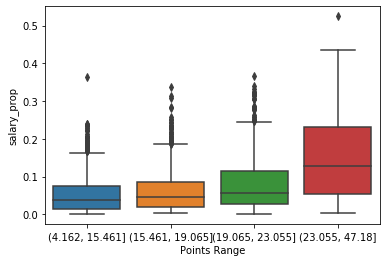

In [13]:
train['cut_points'] = pd.qcut(train['points'], q=4)
ax = sns.boxplot(x="cut_points",y="salary_prop",data=train)
ax = ax.set(xlabel = "Points Range")

We can see that, predictably, points per 48 minutes is positively correlated with proportion of salary cap. 

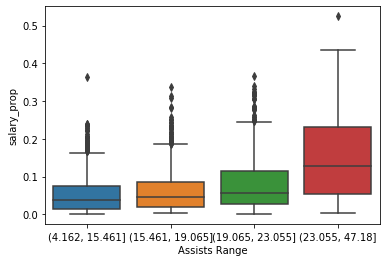

In [15]:
train['cut_assists'] = pd.qcut(train['assists'], q=4)
ax = sns.boxplot(x="cut_points",y="salary_prop",data=train)
ax = ax.set(xlabel = "Assists Range")

Assists per 48 minutes is also positively correlated with proportion of salary cap. 

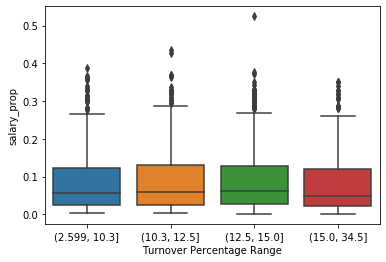

In [16]:
train['cut_turnover_percentage'] = pd.qcut(train['turnover_percentage'], q=4)
ax = sns.boxplot(x="cut_turnover_percentage",y="salary_prop",data=train)
ax = ax.set(xlabel = "Turnover Percentage Range")


Turnover Percentage does not seem to be correlated with salary. An excerpt from this CBS Sports article)[https://www.cbssports.com/nba/news/james-harden-breaks-single-season-turnover-record-and-it-doesnt-matter-at-all/] from 2017 about James Harden breaking the single-season turnover record sheds some light on why this might be: "If you’ve watched the Rockets at all, then you know that their entire attack is predicated on Harden running pick-and-rolls. He is third in the league in scoring, first in assists, first in total minutes and fifth in usage. He has the ball in his hands all the time, and he’s unafraid to make risky passes or dribble into the teeth of the defense. This lends itself to a high turnover rate, and it’s unlikely that anybody in Houston is complaining. Harden, by the way, is in pretty good company. If you look at the NBA’s all-time leaders in turnovers in a season, you’ll see...They're in the Hall of Fame." With all this being said, we will drop Turnover Percentage as it likely will only add noise to the predictions.

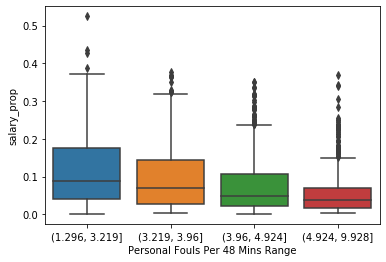

In [17]:
train['cut_pfs'] = pd.qcut(train['personal_fouls'], q=4)
ax = sns.boxplot(x="cut_pfs",y="salary_prop",data=train)
ax = ax.set(xlabel = "Personal Fouls Per 48 Mins Range")

As expected, personal fouls per 48 minutes is negatively associated with salary.